# GHG emissions of Slovakia in a given year

This notebooks details the data preparation and plotting of pie chart showing the greenhouse gas emissions in Slovakia.

In [1]:
from datetime import date
import os
import sys

import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../../"))

from data_analysis.emissions_pie_chart import *
from data_analysis.illustrator_strings import *
from data_analysis.sectors import *
from data_analysis.texts_emissions import *
from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_geo
from data_analysis.eurostat_geo import Geo
from data_analysis.eurostat_population_utils import get_eurostat_population_data_for_geo

### 1. The structure of the pie charts is defined (using CRF codes and EUA permit codes).

In [2]:
GEO = Geo.SK
YEAR = 2023

definition = [
    get_sector_definition(Sector.INDUSTRY) |
    {'breakdown': [
        # Alternative breakdown by companies. This has methodological issues because (minor) parts
        # of emissions from industrial heat plants belong into CRF1A1A - and we can't split that
        # up. This is notable for Ferro Energy (803-007-2018) and CMEPSCO2 (102-050-2013).
        #  {'id': 'us-steel-kosice',
        #   'label': 'U. S. Steel Košice',
        #   'color': '#6e3394',
        #   'codes': ['803-002A-2018'],
        #   'allowances': True},
        #  {'id': 'ferro-energy',
        #   'label': 'Ferro Energy',
        #   'color': '#7a45a1',
        #   'codes': ['803-007-2018'],
        #   'allowances': True},
        #  {'id': 'slovnaft',
        #   'label': 'Slovnaft',
        #   'color': '#7a45a1',
        #   'codes': [
        #       '102-035-2019',  # Slovnaft CO2
        #       '102-050-2013',  # CMEPSCO2 - teplárna (primárně) pro vlastní potřeby
        #   ],
        #   'allowances': True},
        #  {'id': 'duslo',
        #   'label': 'Duslo',
        #   'color': '#7a45a1',
        #   'codes': ['405-01-2017'],
        #   'allowances': True},
        #  {'id': 'cementaren-rohoznik',
        #   'label': 'Cementáreň Rohožník',
        #   'color': '#7a45a1',
        #   'codes': ['106-004-2017'],
        #   'allowances': True},
        #  {'id': 'povazska-cementaren',
        #   'label': 'Považská cementáreň',
        #   'color': '#7a45a1',
        #   'codes': ['302-003-2017'],
        #   'allowances': True},
        get_subsector_definition(Sector.INDUSTRY, Subsector.METAL),
        get_subsector_definition(Sector.INDUSTRY, Subsector.MINERAL),
        get_subsector_definition(Sector.INDUSTRY, Subsector.FUELS),
        {'id': 'other',
         'label': 'Ostatní průmysl',
         'color': get_next_internal_subsector_color(Sector.INDUSTRY),
         'remainder': True},
    ]},
    get_sector_definition(Sector.TRANSPORT) |
    {'breakdown': [
        get_subsector_definition(Sector.TRANSPORT, Subsector.CARS),
        get_subsector_definition(Sector.TRANSPORT, Subsector.TRUCKS_BUSES),
        get_subsector_definition(Sector.TRANSPORT, Subsector.AIRPLANES),
        {'id': 'other',
         'label': 'Ostatní doprava',
         'color': get_next_internal_subsector_color(Sector.TRANSPORT),
         'remainder': True}
    ]},
    get_sector_definition(Sector.BUILDINGS),
    get_sector_definition(Sector.ELECTRICITY_HEAT) |
    {'breakdown': [
         # Invisible subsector for technical computation (for accompanying text).
         get_invisible_subsector_definition() |
         {'id': 'power-plants',
          'codes': [
              '307-002-2017',  # Elektrárna Nováky
              '203-001-2014',  # Elektrárna Malženice
              '807-004-2017',  # Elektrárna Vojany
          ],
          'allowances': True},
         # Invisible subsector for technical computation (for accompanying text).
         get_invisible_subsector_definition() |
         {'id': 'CHP',
          'remainder': True},
     ]},
    get_sector_definition(Sector.AGRICULTURE),
    get_sector_definition(Sector.WASTE),
    get_sector_definition(Sector.OTHER),
]


### 2. Emissions values (in megatons) are loaded for all CRF codes and EUA permit codes that appear in the definition.

In [3]:
df = get_eurostat_crf_data_for_geo(GEO, YEAR)
df

,value
src_crf,
CRF1,24.92736
CRF1A,24.28183
CRF1A1,6.39426
CRF1A1A,3.23962
CRF1A1B,1.88700
...,...
CRF5F3,0.01900
CRF6,0.00000
CRF_INDCO2,0.04108


In [4]:
allowance_permit_codes = []
for wedge_def in definition:
    for sub_wedge in wedge_def.get('breakdown', []):
        allowance_permit_codes += sub_wedge['codes'] if 'allowances' in sub_wedge else []

df_eua = df_eua_filtered = pd.DataFrame()
if allowance_permit_codes:
    df_eua = get_allowances_data(
        YEAR, registry_code=GEO.value, main_activity_code=None, eua_path= f"../../../data/EUA/verified_emissions_{YEAR}_en.xlsx")
    df_eua_filtered = df_eua.loc[df_eua.index.isin(allowance_permit_codes),]
    df = pd.concat([df, df_eua_filtered])

print("Facilities on our list:")
df_eua_filtered

Facilities on our list:


,value,IDENTIFIER_IN_REG,MAIN_ACTIVITY_TYPE_CODE
PERMIT_IDENTIFIER,,,
307-002-2017,0.968387,Elektrárne Nováky,20
203-001-2014,0.338664,PPC Malženice,20
807-004-2017,0.116223,Elektrárne Vojany,20


In [5]:
print("Top facilities not in our list, check them carefully:")
df_eua.loc[~ df_eua.index.isin(allowance_permit_codes),].head(15)

Top facilities not in our list, check them carefully:


,value,IDENTIFIER_IN_REG,MAIN_ACTIVITY_TYPE_CODE
PERMIT_IDENTIFIER,,,
803-002A-2018,5.375510,"U. S. Steel Košice, s.r.o.",20
803-007-2019,2.589212,"U. S. Steel Košice, s.r.o.-FE",20
102-035-2019,1.018878,Slovnaft CO2,21
106-004-2017,0.863884,Danucem SK Cementáreň Rohožník,29
102-050-2013,0.852536,CMEPSCO2,20
405-01-2017,0.794426,Duslo a. s.,41
302-003-2017,0.397716,Považská cementáreň,29
102-048-2012,0.389856,Petrochémia SPC,42
806-001-2012,0.316295,Danucem SK Cementáreň Turňa,29


### 3. List of inner and outer wedges is generated and printed into a CSV file (for processing in Illustrator).

In [6]:
total_value = get_total_emissions_value(df)
inner_wedges = get_emissions_wedges(definition, total_value, df)
inner_dict = {wedge.id: wedge.value for wedge in inner_wedges}

outer_wedges = []
for wedge_def in definition:
    if 'breakdown' in wedge_def:
        parent_id = wedge_def['id']
        parent_value = inner_dict[parent_id]
        outer_wedges += get_emissions_wedges(
            wedge_def['breakdown'], parent_value, df, parent_id)

df_all_wedges = pd.DataFrame(inner_wedges + outer_wedges).set_index("id")
df_wedges = print_emissions_wedges_to_csv(inner_wedges + outer_wedges, f"output-{GEO.value}-wedges.csv")
df_wedges

,value,parent_id,label
id,,,
industry,16.78052,None,Průmysl
transport,7.86738,None,Doprava (včetně letecké)
buildings,4.14580,None,Budovy
electricity-heat,3.23962,None,Výroba elektřiny a tepla
agriculture,2.45557,None,Zemědělství
waste,1.67186,None,Odpadové hospodářství
other,0.10679,None,Jiné
industry_metal,6.45369,industry,Ocel a jiné kovy
industry_mineral,3.10819,industry,Cement a jiné minerály


### 4. Strings (with occasional data) are generated for Illustrator.

In [7]:
population = get_eurostat_population_data_for_geo(GEO, YEAR)
emissions_per_person = total_value * 1_000_000 / population
lulucf_emissions = get_emissions_value("CRF4", df)
lulucf_emissions_abs = abs(lulucf_emissions)
lulucf_emissions_pct = (lulucf_emissions_abs / total_value) * 100

strings: dict[str, str] = {
  "country-name-l": "Slovenska",
  "country-name-g": "Slovenska",
  "year": YEAR,
  "total-weight": czech_float(total_value, 2),
  "total-per-person": czech_float(emissions_per_person, 2),
  "lulucf-emissions-abs": czech_float(lulucf_emissions_abs, 2),
  "lulucf-emissions-pct": czech_float(lulucf_emissions_pct, 0),
  "data-source": "Evropská agentura pro životní prostředí",
  "version": date.today().strftime("%Y-%m-%d"),
  "slug": "emise-sr",
}
df_strings = print_illustrator_strings_to_csv(strings, f"output-{GEO.value}-strings.csv")
df_strings

,value
id,
country-name-l,Slovenska
country-name-g,Slovenska
year,2023
total-weight,"36,27"
total-per-person,"6,68"
lulucf-emissions-abs,"7,78"
lulucf-emissions-pct,21
data-source,Evropská agentura pro životní prostředí
version,2025-09-18


### 5. A nested pie chart is generated (as a rough version of the final plot)

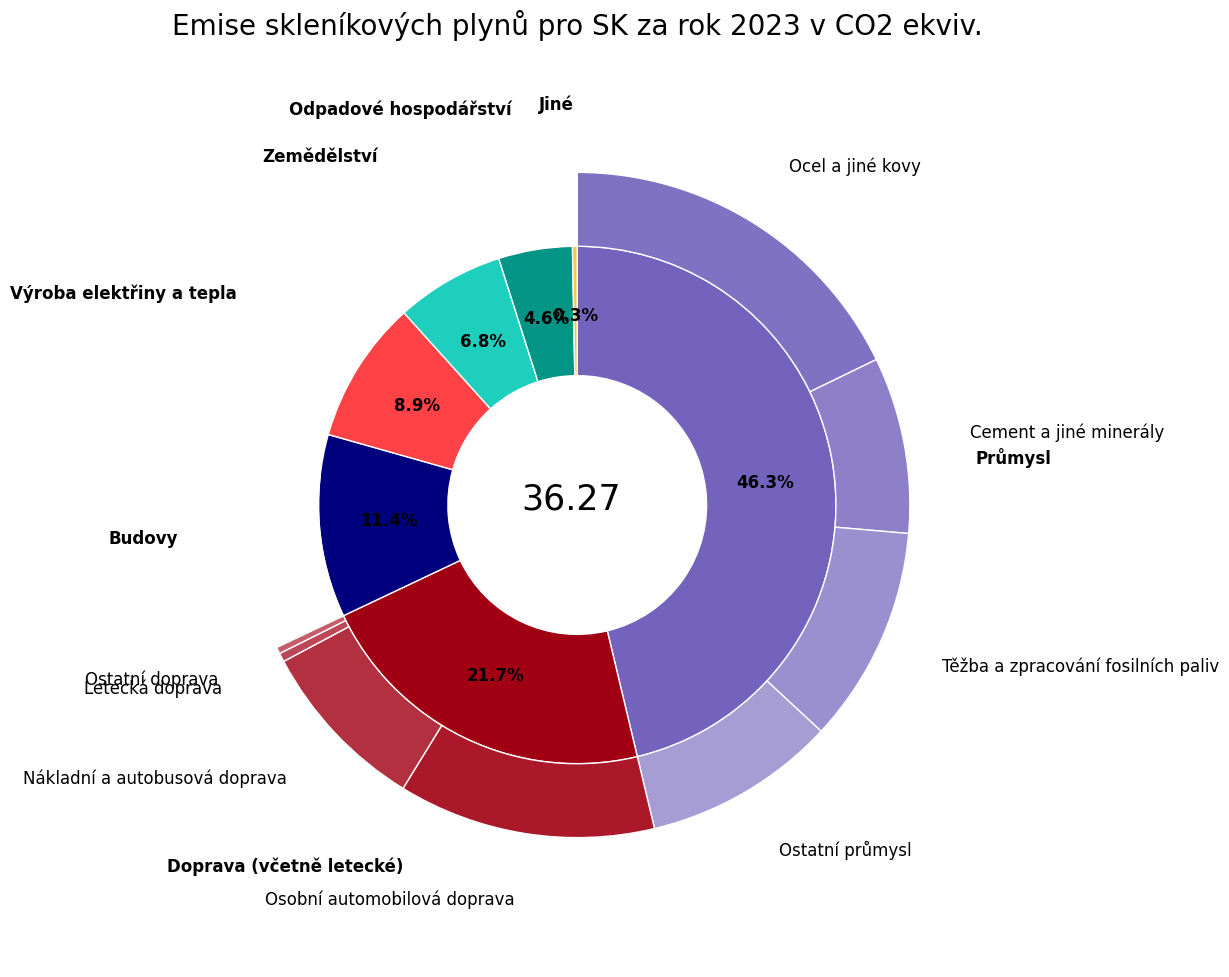

In [8]:
draw_emissions_pie_chart(GEO.value, YEAR, inner_wedges, outer_wedges, total_value)

### 6. Generate accompanying text for the web

Don't forget to update the Google Sheet link!

In [ ]:
accompanying_text = f'''---
layout:     infographic
title:      "Emise skleníkových plynů Slovenska podle sektorů"
slug:       "{strings["slug"]}"
redirect_from: "/{strings["slug"]}"
published:  2020-10-14
weight:     97
tags-scopes: [ eu ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) na Slovensku za rok {YEAR} v jednotlivých sektorech lidské činnosti. Roční objem emisí Slovenska je {strings["total-weight"]} mil. tun. V přepočtu na obyvatele to je {strings["total-per-person"]} t CO<sub>2</sub>eq na obyvatele."
data-orig:
  - [ "Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions/pie-charts/SK.ipynb" ]
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on {strings["version"]}. Do not change here, fix it in the source notebook."
---

## Jak číst tento graf a co znamenají jednotlivé sektory?

{get_gases_info()}

Roční objem emisí Slovenska je {czech_float(total_value, 2)} mil. tun CO<sub>2</sub>eq (údaj z roku {YEAR}). __V přepočtu na obyvatele to je {czech_float(emissions_per_person, 2)} t CO<sub>2</sub>eq/obyvatele.__

* {get_sectoral_info(Sector.INDUSTRY, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.TRANSPORT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.BUILDINGS, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.ELECTRICITY_HEAT, GEO, df_all_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.AGRICULTURE, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.WASTE, GEO, df_wedges, df, total_value, population)}

{get_lulucf_info(YEAR, GEO, lulucf_emissions)}

## Poznámky k datům o emisích

{get_methodology_info()}

{get_trade_and_flights_info(GEO)}
'''
print(accompanying_text)


---
layout:     infographic
title:      "Emise skleníkových plynů Slovenska podle sektorů"
slug:       "emise-sr"
redirect_from: "/emise-sr"
published:  2020-10-14
weight:     97
tags-scopes: [ eu ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) na Slovensku za rok 2023 v jednotlivých sektorech lidské činnosti. Roční objem emisí Slovenska je 36,27 mil. tun. V přepočtu na obyvatele to je 6,68 t CO<sub>2</sub>eq na obyvatele."
data-our:   "https://docs.google.com/spreadsheets/d/1FIuOP9Q58_0LEEuuhggXpuAnvRcs13e8H1buZKWJB3Y/edit?usp=sharing"
data-orig:
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
  - [ "European Commission", "https://climate.ec.europa.eu/document/download/9e3ed91e-5820-47d1-8b6f-f99b9a67172e_en?filename=verified_emissions_2018_en.xlsx" ]
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on 2025-09-18. Do not change here, fix i